In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import psycopg2
import pandas as pd
import psycopg2.extras
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/27264574/import-psycopg2-library-not-loaded-libssl-1-0-0-dylib
# Fixes annoying import error:
# export DYLD_FALLBACK_LIBRARY_PATH=$HOME/anaconda/lib/:$DYLD_FALLBACK_LIBRARY_PATH
# put this in ~/.bash_profile

def get_df(sql):
    connection_string = "host='localhost' dbname='nfldb' user='postgres' password='postgres' port=5432"
    connection = psycopg2.connect(connection_string)
    cursor = connection.cursor()
    cursor.execute(sql)
    columns = [desc[0] for desc in cursor.description]
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=columns)
    cursor.close()
    connection.close()
    return df

/Users/ryanzotti/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


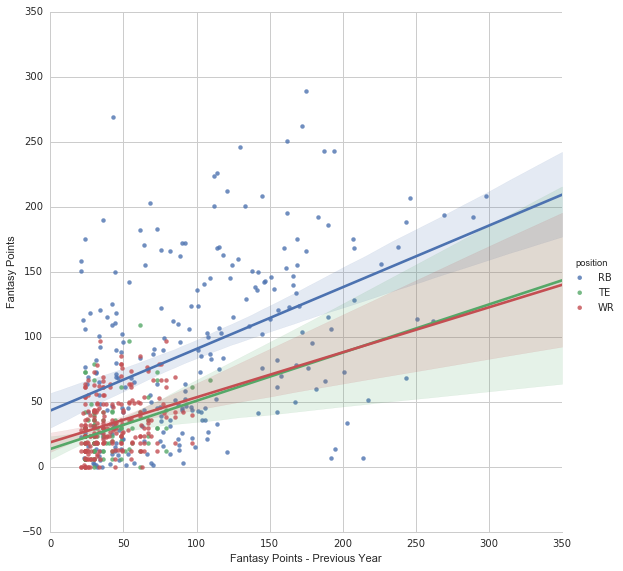

In [26]:
sql = '''
    CREATE TEMP TABLE player_season_totals
        AS
   (SELECT game.season_year, player.player_id, player.full_name, 
           player.position,
           SUM(receiving_yds) AS receiving_yds,
           SUM(receiving_tds) AS receiving_tds,
           SUM(receiving_twoptm) AS receiving_twoptm,
           SUM(receiving_rec) AS receiving_rec,
           SUM(rushing_yds) AS rushing_yds,
           SUM(rushing_tds) AS rushing_tds,
           SUM(rushing_twoptm) AS rushing_twoptm,
           SUM(rushing_att) AS rushing_att,
           SUM(receiving_tds) + SUM(rushing_tds) AS total_tds,
           SUM(receiving_yds) + SUM(rushing_yds) AS total_yds,
           ((SUM(receiving_tds) + SUM(rushing_tds))*6) +
           ((SUM(receiving_twoptm) + SUM(rushing_twoptm))*2) +
           ((SUM(receiving_tds) + SUM(rushing_yds))/10) AS fantasy_pts
      FROM play_player
      LEFT JOIN player
           ON play_player.player_id = player.player_id
      LEFT JOIN game
           ON play_player.gsis_id = game.gsis_id
     WHERE LOWER(game.season_type::TEXT) NOT IN ('postseason','preseason')
           AND player.position IN ('RB','WR','TE')
     GROUP BY game.season_year, player.player_id, player.full_name, player.position);
     
    SELECT a.player_id, 
           a.full_name, 
           a.season_year AS target_season, 
           a.position,
           b.season_year AS prev_season, 
           a.fantasy_pts AS target_fantasy_pts,
           b.fantasy_pts AS prev_fantasy_pts,
           b.total_tds,
           b.total_yds,
           b.receiving_rec,
           b.rushing_att
      FROM player_season_totals AS a
      JOIN player_season_totals AS b
           ON a.season_year = b.season_year + 1
               AND a.player_id = b.player_id
     WHERE b.fantasy_pts > 20
'''

df = get_df(sql)
sns.set(style='whitegrid')
%matplotlib inline
sns.lmplot('prev_fantasy_pts','target_fantasy_pts',data=df,hue='position', size=8, aspect=1)
plt.xlabel('Fantasy Points - Previous Year')
plt.ylabel('Fantasy Points')
mpl.rcParams['figure.figsize'] = (100,100)
plt.show()


In [38]:
from sklearn.linear_model import LinearRegression
import operator
from sklearn.metrics import mean_squared_error
from math import sqrt

numeric_cols = ['target_fantasy_pts',
                'prev_fantasy_pts',
                'total_tds',
                'total_yds',
                'receiving_rec',
                'rushing_att']
df[numeric_cols] = df[numeric_cols].astype(float)
predictors = ['prev_fantasy_pts',
              'total_tds',
              'total_yds',
              'receiving_rec',
              'rushing_att']
train = df[(df['target_season'].isin([2010,2012,2014,2016])) & (df['position']=='RB')]
validation = df[(df['target_season'].isin([2011,2013,2015])) & (df['position']=='RB')]

results = {}
target_name = 'target_fantasy_pts'
for predictor in predictors:
    linear_regression = LinearRegression()
    model = linear_regression.fit(train[[predictor]], train[target_name])
    rmse = sqrt(mean_squared_error(validation[target_name],model.predict(validation[[predictor]])))
    results[predictor]= rmse
    
sorted(results.items(), key=operator.itemgetter(1))

[('rushing_att', 54.87965541433224),
 ('total_yds', 55.47853427076034),
 ('prev_fantasy_pts', 57.209457600073655),
 ('receiving_rec', 60.198444546672874),
 ('total_tds', 60.88763617652237)]

In [39]:
from sklearn.linear_model import LinearRegression
import operator
from sklearn.metrics import mean_squared_error
from math import sqrt

numeric_cols = ['target_fantasy_pts',
                'prev_fantasy_pts',
                'total_tds',
                'total_yds',
                'receiving_rec',
                'rushing_att']
df[numeric_cols] = df[numeric_cols].astype(float)
predictors = ['prev_fantasy_pts',
              'total_tds',
              'total_yds',
              'receiving_rec',
              'rushing_att']
train = df[(df['target_season'].isin([2010,2012,2014,2016])) & (df['position']=='WR')]
validation = df[(df['target_season'].isin([2011,2013,2015])) & (df['position']=='WR')]

results = {}
target_name = 'target_fantasy_pts'
for predictor in predictors:
    linear_regression = LinearRegression()
    model = linear_regression.fit(train[[predictor]], train[target_name])
    rmse = sqrt(mean_squared_error(validation[target_name],model.predict(validation[[predictor]])))
    results[predictor]= rmse
    
sorted(results.items(), key=operator.itemgetter(1))

[('total_yds', 21.58372256593674),
 ('receiving_rec', 21.898929223170942),
 ('prev_fantasy_pts', 21.939757950561397),
 ('total_tds', 21.958077844891047),
 ('rushing_att', 22.77319680353816)]

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
import operator
from sklearn.metrics import mean_squared_error
from math import sqrt

numeric_cols = ['target_fantasy_pts',
                'prev_fantasy_pts',
                'total_tds',
                'total_yds',
                'receiving_rec',
                'rushing_att']
df[numeric_cols] = df[numeric_cols].astype(float)
predictors = ['prev_fantasy_pts',
              'total_tds',
              'total_yds',
              'receiving_rec',
              'rushing_att']
train = df[(df['target_season'].isin([2010,2012,2014,2016])) & (df['position']=='RB')]
validation = df[(df['target_season'].isin([2011,2013,2015])) & (df['position']=='RB')]

params = {'n_estimators':10, 'max_depth':4, 'min_samples_split':2, 'learning_rate':0.1, 'loss': 'ls'}
results = {}
target_name = 'target_fantasy_pts'
for predictor in predictors:
    gbm = GradientBoostingRegressor(**params)
    model = gbm.fit(train[[predictor]], train[target_name])
    rmse = sqrt(mean_squared_error(validation[target_name],model.predict(validation[[predictor]])))
    results[predictor]= rmse
    
sorted(results.items(), key=operator.itemgetter(1))

[('rushing_att', 56.94195120807008),
 ('prev_fantasy_pts', 57.345677831167045),
 ('total_yds', 61.39335987409199),
 ('total_tds', 61.92657687068104),
 ('receiving_rec', 65.64910849320958)]